In this demo we will analyze the mechanical vibration of a quadrotor during flight using publicly available logs.

We obtain the logs from review.px4.io, https://review.px4.io/plot_app?log=8aa57955-db73-46d5-8800-17903bbc3575

# Open the file

In [1]:
%pylab inline

import pyulog

with open('data/8aa57955-db73-46d5-8800-17903bbc3575.ulg', 'rb') as f:
    log = pyulog.ULog(f)

Populating the interactive namespace from numpy and matplotlib


# List the Data Topics

In [2]:
for data in log.data_list:
    print(data.name)

vehicle_local_position_setpoint
vehicle_magnetometer
vehicle_air_data
ekf2_timestamps
vehicle_status_flags
vehicle_status
vehicle_rates_setpoint
vehicle_local_position
vehicle_land_detected
vehicle_gps_position
vehicle_global_position
vehicle_attitude_setpoint
vehicle_attitude
telemetry_status
system_power
sensor_preflight
sensor_combined
safety
rate_ctrl_status
manual_control_setpoint
input_rc
home_position
estimator_status
ekf2_innovations
distance_sensor
cpuload
battery_status
actuator_outputs
actuator_outputs
actuator_controls_0


# Plot the raw x acceleration, about the aircraft roll axis

In [3]:
sensor = log.get_dataset('sensor_combined')

Text(0, 0.5, 'accel m/s^2')

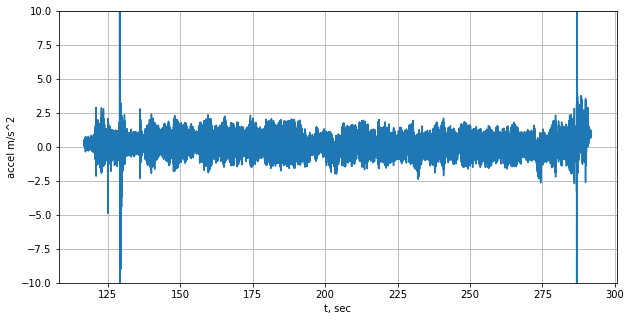

In [4]:
accx = sensor.data['accelerometer_m_s2[0]']
t = sensor.data['timestamp']/1.0e6
plt.figure(figsize=(10, 5))
plt.plot(t, accx)
plt.gca().set_ylim(-10, 10)
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('accel m/s^2')

## Compute the Sample Time

(0.004021126940387619, 248.68650376493818)

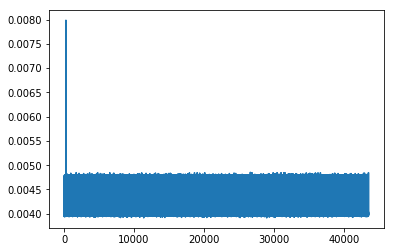

In [5]:
plt.plot(np.diff(t))
Ts = np.mean(np.diff(t))
Ts, 1/Ts

## Find the Vibrational Frequencies

In [6]:
def plot_fft(t, y):
    n = len(y)
    Y = (2/n)*np.fft.fft(y)
    n_half = int(np.ceil(n/2))
    freq = np.fft.fftfreq(n, Ts)
    plt.plot(freq[:n_half], np.abs(Y[:n_half]))
    plt.xlabel('Hz')
    plt.grid()

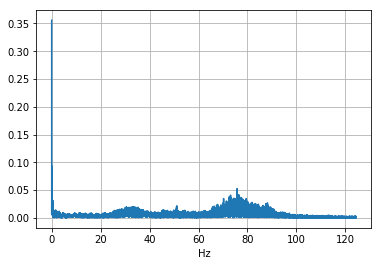

In [7]:
plot_fft(t, accx)

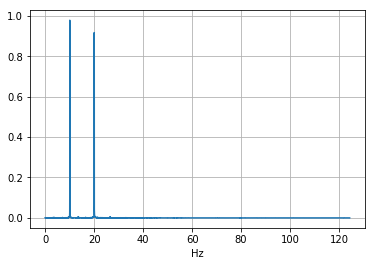

In [8]:
test_sig = np.sin(2*np.pi*20*t) + np.sin(2*np.pi*10*t)
plot_fft(t, test_sig)

# Attitude Rates Control Response

(-90, 60)

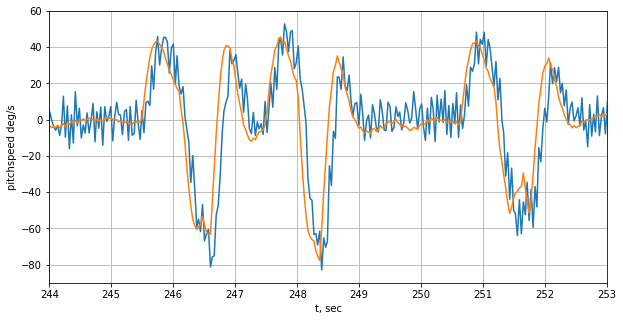

In [109]:
def plot_rate_response(log, name):
    attitude = log.get_dataset('vehicle_attitude')
    rates_setpoint = log.get_dataset('vehicle_rates_setpoint')
    t = attitude.data['timestamp']/1e6
    y = attitude.data[name + 'speed']
    t_u = rates_setpoint.data['timestamp']/1e6
    u = rates_setpoint.data[name]
    plt.plot(t, np.rad2deg(y))
    plt.plot(t_u, np.rad2deg(u))
    plt.xlabel('t, sec')
    plt.ylabel(name + 'speed deg/s')
    plt.grid()

plt.figure(figsize=(10, 5))
plot_rate_response(log, 'pitch')
plt.gca().set_xlim([244, 253]);
plt.gca().set_ylim([-90, 60])

In [151]:
import sysid

def find_plant(log, name, t0, t1, dt):
    attitude = log.get_dataset('vehicle_attitude')
    rates_setpoint = log.get_dataset('vehicle_rates_setpoint')
    t = attitude.data['timestamp']/1e6
    y = attitude.data[name + 'speed']
    t_u = rates_setpoint.data['timestamp']/1e6
    u = rates_setpoint.data[name]
    y_r = []
    u_r = []
    for ti in np.arange(t0, t1, dt):
        y_r.append(np.interp(ti, t, y))
        u_r.append(np.interp(ti, t_u, u))
    y_r = np.array(y_r)
    u_r = np.array(u_r)
    
    sys = sysid.subspace_det_algo1(y_r, u_r, 6, 3, 0.001, 0.01)
    return sys

In [172]:
sys = find_plant(log, 'roll', 245, 252, 0.1)
sys

{'A': matrix([[ 0.03910178, -0.78206731, -0.3128225 ],
        [ 0.84607524, -0.04230229, -0.40133415],
        [-0.26551744, -0.58478452, -0.09965301]]), 'B': matrix([[ 0.25414283],
        [-0.06133811],
        [ 0.21625683]]), 'C': matrix([[-0.07188165,  0.47217994,  0.95978359]]), 'D': matrix([[0.14314027]]), 'Q': matrix([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), 'R': matrix([[0.]]), 'dt': 0.01}

In [173]:
import control

In [175]:
sys = control.ss(sys.A, sys.B, sys.C, sys.D, sys.dt)
sys

A = [[ 0.03910178 -0.78206731 -0.3128225 ]
 [ 0.84607524 -0.04230229 -0.40133415]
 [-0.26551744 -0.58478452 -0.09965301]]

B = [[ 0.25414283]
 [-0.06133811]
 [ 0.21625683]]

C = [[-0.07188165  0.47217994  0.95978359]]

D = [[0.14314027]]

dt = 0.01

In [177]:
G_d = control.ss2tf(sys)
G_d


0.1431 z^2 + 0.1751 z + 0.07698
-------------------------------
    z^2 + 0.1029 z + 0.3426

dt = 0.01